## BalanceNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...
[+] Using Keras version 2.4.3
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7733. 13106. 12693.  3427.   872.]
[+] Validation:
 [1910. 3191. 3245.  874.  237.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [2]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [3]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [4]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [5]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [6]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [7]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [8]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [9]:
!rm -r logs

In [10]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [11]:
model.summary()
model.save('BalanceNet.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 30, 12)       9936        embedding[0][0]                  
______________________________________________________________________________________________

In [12]:
# model = keras.models.load_model("checkpoint-0.91.h5")

Time to train!!

In [13]:
print("Training Progress:")
import pandas
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=40, batch_size=128,
          callbacks=[tensorboard, model_checkpoints])

pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
Epoch 1/40
296/296 [==============================] - 19s 41ms/step - loss: 1.2987 - acc: 0.4100 - val_loss: 1.0923 - val_acc: 0.5540
Epoch 2/40
296/296 [==============================] - 10s 34ms/step - loss: 1.0522 - acc: 0.5594 - val_loss: 0.9943 - val_acc: 0.6022
Epoch 3/40
296/296 [==============================] - 10s 34ms/step - loss: 0.9843 - acc: 0.5903 - val_loss: 0.9597 - val_acc: 0.6143
Epoch 4/40
296/296 [==============================] - 10s 34ms/step - loss: 0.9581 - acc: 0.6047 - val_loss: 0.9480 - val_acc: 0.6132
Epoch 5/40
296/296 [==============================] - 10s 34ms/step - loss: 0.9410 - acc: 0.6107 - val_loss: 0.9369 - val_acc: 0.6222
Epoch 6/40
296/296 [==============================] - 10s 34ms/step - loss: 0.9289 - acc: 0.6206 - val_loss: 0.9411 - val_acc: 0.6255
Epoch 7/40
296/296 [==============================] - 10s 34ms/step - loss: 0.9251 - acc: 0.6202 - val_loss: 0.9319 - val_acc: 0.6190
Epoch 8/40
296/296 [=======================

KeyboardInterrupt: 

## Model Testing and Inference

In [14]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]

In [15]:
! ls

architectures	      checkpoint-0.932.h5  checkpoint-1.092.h5
BalanceNet-1.0.ipynb  checkpoint-0.933.h5  checkpoint-1.107.h5
BalanceNet.h5	      checkpoint-0.934.h5  ClassMerge.ipynb
checkpoint-0.907.h5   checkpoint-0.935.h5  _config.yml
checkpoint-0.908.h5   checkpoint-0.936.h5  data.csv
checkpoint-0.909.h5   checkpoint-0.937.h5  dataset
checkpoint-0.910.h5   checkpoint-0.940.h5  experiments
checkpoint-0.911.h5   checkpoint-0.943.h5  ExtraFunctions.ipynb
checkpoint-0.912.h5   checkpoint-0.944.h5  history-balance.csv
checkpoint-0.913.h5   checkpoint-0.948.h5  images
checkpoint-0.914.h5   checkpoint-0.950.h5  logs
checkpoint-0.917.h5   checkpoint-0.952.h5  ProcessData-Crawled.ipynb
checkpoint-0.918.h5   checkpoint-0.960.h5  ProcessData.ipynb
checkpoint-0.919.h5   checkpoint-0.961.h5  raw_data
checkpoint-0.920.h5   checkpoint-0.962.h5  README.md
checkpoint-0.922.h5   checkpoint-0.976.h5  run_tensorboard.sh
checkpoint-0.923.h5   checkpoint-0.988.h5  Setup.ipynb
checkpoint-0.924.h5   checkp

In [16]:
# model = load_model('checkpoint-1.081.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [17]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.49      0.38      0.43      1910
       happy       0.64      0.70      0.67      3191
         sad       0.62      0.69      0.65      3245
        hate       0.83      0.64      0.73       874
       anger       0.92      0.67      0.78       237

    accuracy                           0.63      9457
   macro avg       0.70      0.62      0.65      9457
weighted avg       0.63      0.63      0.62      9457



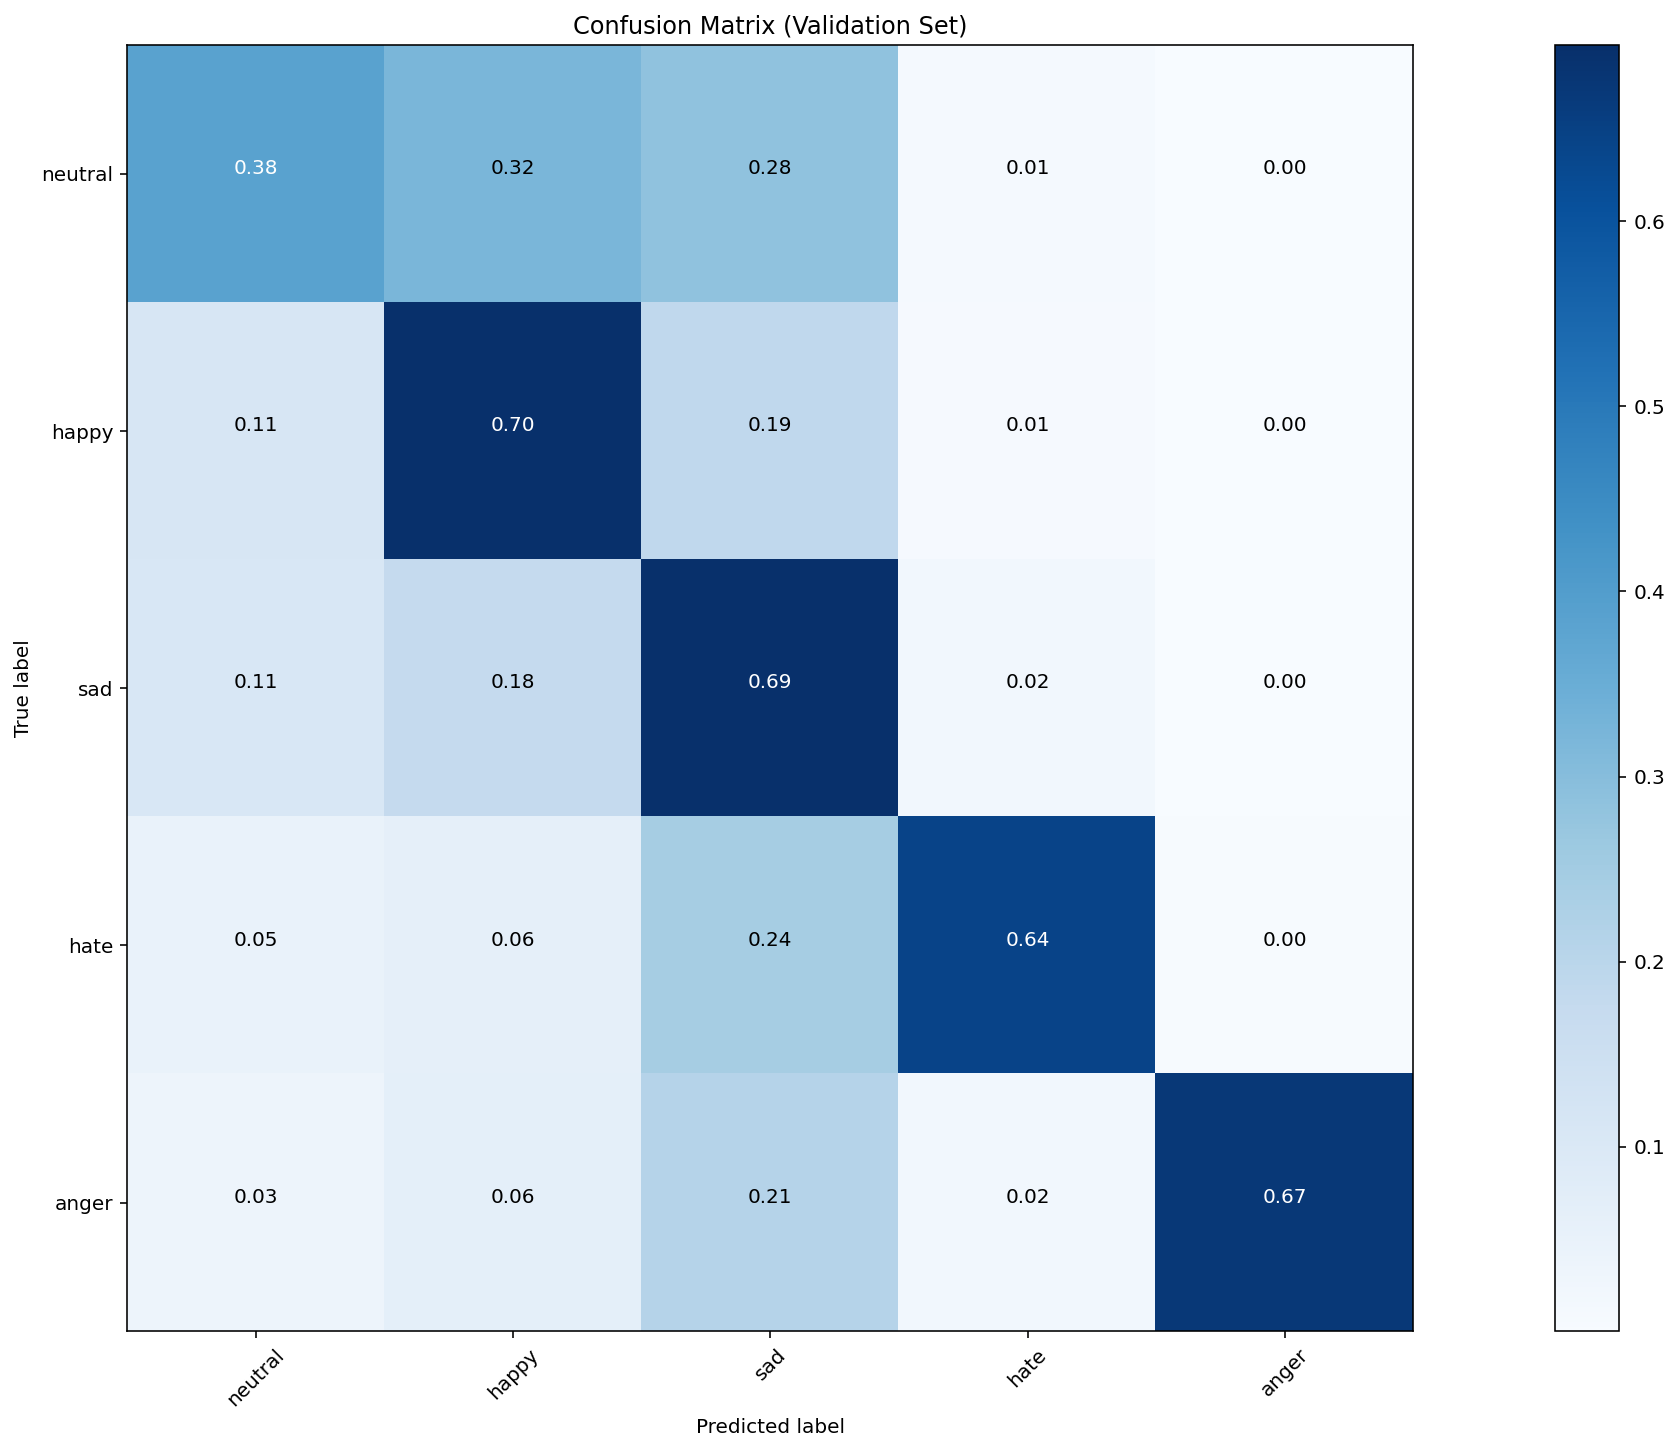

In [18]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [149]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        "PAP are taking the piss again!",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [150]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: sad 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: sad 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: sad 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: neutral 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: sad 



# Prediction start

In [19]:
import pandas as pd
import matplotlib
df_trump = pd.read_csv('./dataset/trump.csv')

In [20]:
df_trump['Text_After_Clean'] = df_trump['Text_After_Clean'].apply(lambda x: eval(x))
df_trump['Text_After_Clean'] 

0        [like deep imaginary work man pocket pay priva...
1        [donald trump robot control alien look like to...
2                [go crazy time way trump end candidate, ]
3        [miss trump, oh look paul fail year, palin gai...
4        [gt;real estate mogul donald trump say friday ...
                               ...                        
54010    [gt trumplikan script lie dems gt;trump hitler...
54011    [trump supporter tie knot try find narrative, ...
54012    [gt;"washington trump administration cancel gr...
54013    [gt fact straight fuck retard, job occur trump...
54014    [hahahahaha leftist number, guess logic intell...
Name: Text_After_Clean, Length: 54015, dtype: object

In [21]:
df_trump['dateTime'] = pd.to_datetime(df_trump['timestamp'], unit='s')

In [22]:
mask = df_trump['dateTime'] < '2016-1-1'
mask_r = df_trump['dateTime'] >= '2016-1-1'

df_trump_sample = df_trump.loc[mask]
df_trump_out = df_trump.loc[mask_r]

In [23]:
df_trump_sample

,index,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,dateTime,Text_After_Clean,emotions
0,31684,1284827804,I would like to see how deep this imaginary wo...,nuncamas,c0zuipn,dfmx5,1,c0zuipn,1426474702,0,NaN,AmericanPolitics,False,NaN,NaN,2010-09-18 16:36:44,[like deep imaginary work man pocket pay priva...,[]
1,32146,1303304147,donald trump is an robot controlled by an alie...,CodeandOptics,gu2an,gu2an,2,c1qd4r7,1427083260,0,NaN,AmericanPolitics,False,NaN,NaN,2011-04-20 12:55:47,[donald trump robot control alien look like to...,[]
2,32155,1303964664,"It is only going to get crazier, but at the sa...",erikmyxter,gyut8,gyut8,2,c1rcblx,1427100174,0,NaN,AmericanPolitics,False,NaN,NaN,2011-04-28 04:24:24,"[go crazy time way trump end candidate, ]",[]
3,32245,1306525263,I miss Trump already. Oh look Paul might fail ...,[deleted],hkwyw,hkwyw,1,c1wdwh7,1427187576,0,NaN,AmericanPolitics,False,NaN,NaN,2011-05-27 19:41:03,"[miss trump, oh look paul fail year, palin gai...",[]
4,32548,1312341490,&gt;Real estate mogul Donald Trump said Friday...,thebrightsideoflife,j7d2p,j7d2p,1,c29r2eq,1427424678,0,NaN,AmericanPolitics,False,NaN,NaN,2011-08-03 03:18:10,[gt;real estate mogul donald trump say friday ...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29938,4165066,1451412945,"Kek\n\nTrump is love, Trump is life.\n\n\n\n",Barely_Intrepid,cyf4m67,3ynfe2,2,cyf2q1o,1451922113,0,NaN,POLITIC,False,NaN,NaN,2015-12-29 18:15:45,"[kek trump love trump life, ]",[]
29939,4165110,1451465172,yea i like it too. trump is fucking hilarious...,sheasie,cyb0ipi,3y6kqp,2,cyb0ipi,1451936265,0,NaN,POLITIC,False,NaN,NaN,2015-12-30 08:46:12,"[yea like, trump fuck hilarious, potus materia...",[]
29940,4165166,1451520545,"I may not yet trust Trump, but other politicia...",Redpaw_Designs2,3yu6wk,3yu6wk,1,cygqhvj,1451949450,0,NaN,POLITIC,False,NaN,NaN,2015-12-31 00:09:05,[trust trump politician earn disrespect decade],[]
29941,4165188,1451537573,Pseudo-intellectual bullshit at a high level. ...,aksack,3yu6wk,3yu6wk,0,cygzsak,1451953899,0,NaN,POLITIC,False,NaN,NaN,2015-12-31 04:52:53,"[pseudo intellectual bullshit high level, cons...",[]


In [24]:
df_trump_down = df_trump_sample.append(df_trump_out.sample(frac=0.05), ignore_index=True)
df_trump_down

,index,timestamp,text,speaker,reply_to,conversation_id,meta.score,meta.top_level_comment,meta.retrieved_on,meta.gilded,meta.gildings,meta.subreddit,meta.stickied,meta.permalink,meta.author_flair_text,dateTime,Text_After_Clean,emotions
0,31684,1284827804,I would like to see how deep this imaginary wo...,nuncamas,c0zuipn,dfmx5,1,c0zuipn,1426474702,0,NaN,AmericanPolitics,False,NaN,NaN,2010-09-18 16:36:44,[like deep imaginary work man pocket pay priva...,[]
1,32146,1303304147,donald trump is an robot controlled by an alie...,CodeandOptics,gu2an,gu2an,2,c1qd4r7,1427083260,0,NaN,AmericanPolitics,False,NaN,NaN,2011-04-20 12:55:47,[donald trump robot control alien look like to...,[]
2,32155,1303964664,"It is only going to get crazier, but at the sa...",erikmyxter,gyut8,gyut8,2,c1rcblx,1427100174,0,NaN,AmericanPolitics,False,NaN,NaN,2011-04-28 04:24:24,"[go crazy time way trump end candidate, ]",[]
3,32245,1306525263,I miss Trump already. Oh look Paul might fail ...,[deleted],hkwyw,hkwyw,1,c1wdwh7,1427187576,0,NaN,AmericanPolitics,False,NaN,NaN,2011-05-27 19:41:03,"[miss trump, oh look paul fail year, palin gai...",[]
4,32548,1312341490,&gt;Real estate mogul Donald Trump said Friday...,thebrightsideoflife,j7d2p,j7d2p,1,c29r2eq,1427424678,0,NaN,AmericanPolitics,False,NaN,NaN,2011-08-03 03:18:10,[gt;real estate mogul donald trump say friday ...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,4245701,1512748382,"Youisunderstsnd they maybe, but the are trying...",Just_Relax_and_Chill,dqy0i4b,7i90ms,1,dqxrjmo,1514485641,0,NaN,POLITIC,False,/r/POLITIC/comments/7i90ms/trump_team_didnt_ju...,NaN,2017-12-08 15:53:02,[youisunderstsnd maybe try convince representa...,[]
5003,4320414,1537369383,This is why President Trump is personally turn...,DonnieS1,9h5wja,9h5wja,3,e69b9ts,1539292095,0,"{'gid_1': 0, 'gid_2': 0, 'gid_3': 0}",POLITIC,False,/r/POLITIC/comments/9h5wja/voters_arent_politi...,NaN,2018-09-19 15:03:03,[president trump personally turn great blue wa...,[]
5004,61985,1524096494,I still don’t understand why this was announce...,WillieM96,8d9vw2,8d9vw2,1,dxlk0lh,1526484413,0,NaN,AmericanPolitics,False,/r/AmericanPolitics/comments/8d9vw2/actually_c...,NaN,2018-04-19 00:08:14,[understand announce investigation trump possi...,[]
5005,4222705,1493756918,Fuck you Donald Trump.,BufferingPleaseWait,68v0b7,68v0b7,0,dh1n7lc,1496204218,0,NaN,POLITIC,False,NaN,NaN,2017-05-02 20:28:38,[fuck donald trump],[]


In [25]:
def predictDf(text):
    sequences_test = tokenizer.texts_to_sequences(text)
    data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
    data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
    y_prob = model.predict(data_test)
    predict = []
    for n, prediction in enumerate(y_prob):
        pred = y_prob.argmax(axis=-1)[n]
        predict.append(classes[pred])
    return predict

In [26]:
df_trump_down['emotion'] = df_trump_down['Text_After_Clean'].apply(lambda x: predictDf(x))

In [27]:
# df_trump_down.to_csv('./dataset/trump_down.csv', index=False)

In [28]:
df_trump_down['emotion']

0                               [anger, neutral, neutral]
1                                                 [anger]
2                                      [neutral, neutral]
3                            [sad, sad, neutral, neutral]
4                                 [neutral, sad, neutral]
                              ...                        
5002                          [neutral, neutral, neutral]
5003                                              [happy]
5004                                   [neutral, neutral]
5005                                               [hate]
5006    [neutral, neutral, hate, neutral, sad, hate, n...
Name: emotion, Length: 5007, dtype: object

In [74]:
df_trump_ts = df_trump_down[['text', 'timestamp', 'dateTime', 'emotion']]

In [75]:
df_trump_ts['anger'] = ''
df_trump_ts['happy'] = ''
df_trump_ts['hate'] = ''
df_trump_ts['neutral'] = ''
df_trump_ts['sad'] = ''

<ipython-input-75-0672f373453b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump_ts['anger'] = ''
<ipython-input-75-0672f373453b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump_ts['happy'] = ''
<ipython-input-75-0672f373453b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [76]:
def one_hot_modify(row):
    for x in classes:
        row[x] = row['emotion'].count(x)
    return row

In [77]:
for index, row in df_trump_ts.iterrows():
    temprow = one_hot_modify(row)
    df_trump_ts.loc[index] = temprow
df_trump_ts

/home/kai/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1700: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


,text,timestamp,dateTime,emotion,anger,happy,hate,neutral,sad
0,I would like to see how deep this imaginary wo...,1284827804,2010-09-18 16:36:44,"[anger, neutral, neutral]",1,0,0,2,0
1,donald trump is an robot controlled by an alie...,1303304147,2011-04-20 12:55:47,[anger],1,0,0,0,0
2,"It is only going to get crazier, but at the sa...",1303964664,2011-04-28 04:24:24,"[neutral, neutral]",0,0,0,2,0
3,I miss Trump already. Oh look Paul might fail ...,1306525263,2011-05-27 19:41:03,"[sad, sad, neutral, neutral]",0,0,0,2,2
4,&gt;Real estate mogul Donald Trump said Friday...,1312341490,2011-08-03 03:18:10,"[neutral, sad, neutral]",0,0,0,2,1
...,...,...,...,...,...,...,...,...,...
5002,"Youisunderstsnd they maybe, but the are trying...",1512748382,2017-12-08 15:53:02,"[neutral, neutral, neutral]",0,0,0,3,0
5003,This is why President Trump is personally turn...,1537369383,2018-09-19 15:03:03,[happy],0,1,0,0,0
5004,I still don’t understand why this was announce...,1524096494,2018-04-19 00:08:14,"[neutral, neutral]",0,0,0,2,0
5005,Fuck you Donald Trump.,1493756918,2017-05-02 20:28:38,[hate],0,0,1,0,0


In [78]:
per = df_trump_ts.dateTime.dt.to_period("Q")
g = df_trump_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']
df_mg = g.sum()
df_mg.head()

<ipython-input-78-15bc50b04012>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g = df_trump_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']


,anger,happy,hate,neutral,sad
dateTime,,,,,
2010Q3,1,0,0,2,0
2011Q2,1,0,0,4,2
2011Q3,0,1,3,4,2
2011Q4,0,1,2,2,1
2012Q1,0,2,2,27,13


In [79]:
df_mg['total'] = df_mg['anger'] + df_mg['happy'] + df_mg['hate'] + df_mg['neutral']  + df_mg['sad']

df_mg['anger_per'] = df_mg['anger']/df_mg['total']
df_mg['happy_per'] = df_mg['happy']/df_mg['total']
df_mg['hate_per'] = df_mg['hate']/df_mg['total']
df_mg['neutral_per'] = df_mg['neutral']/df_mg['total']
df_mg['sad_per'] = df_mg['sad']/df_mg['total']
df_mg

,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per
dateTime,,,,,,,,,,,
2010Q3,1,0,0,2,0,3,0.333333,0.000000,0.000000,0.666667,0.000000
2011Q2,1,0,0,4,2,7,0.142857,0.000000,0.000000,0.571429,0.285714
2011Q3,0,1,3,4,2,10,0.000000,0.100000,0.300000,0.400000,0.200000
2011Q4,0,1,2,2,1,6,0.000000,0.166667,0.333333,0.333333,0.166667
2012Q1,0,2,2,27,13,44,0.000000,0.045455,0.045455,0.613636,0.295455
2012Q2,2,10,34,95,69,210,0.009524,0.047619,0.161905,0.452381,0.328571
2012Q3,6,16,36,121,43,222,0.027027,0.072072,0.162162,0.545045,0.193694
2012Q4,6,50,118,449,155,778,0.007712,0.064267,0.151671,0.577121,0.199229
2013Q1,3,53,120,336,199,711,0.004219,0.074543,0.168776,0.472574,0.279887


In [80]:
print('angle ' + str(df_mg['anger'].sum()))
print('happy ' + str(df_mg['happy'].sum()))
print('hate ' + str(df_mg['hate'].sum()))
print('neutral ' + str(df_mg['neutral'].sum()))
print('sad ' + str(df_mg['sad'].sum()))

angle 409
happy 1861
hate 6836
neutral 15552
sad 7429


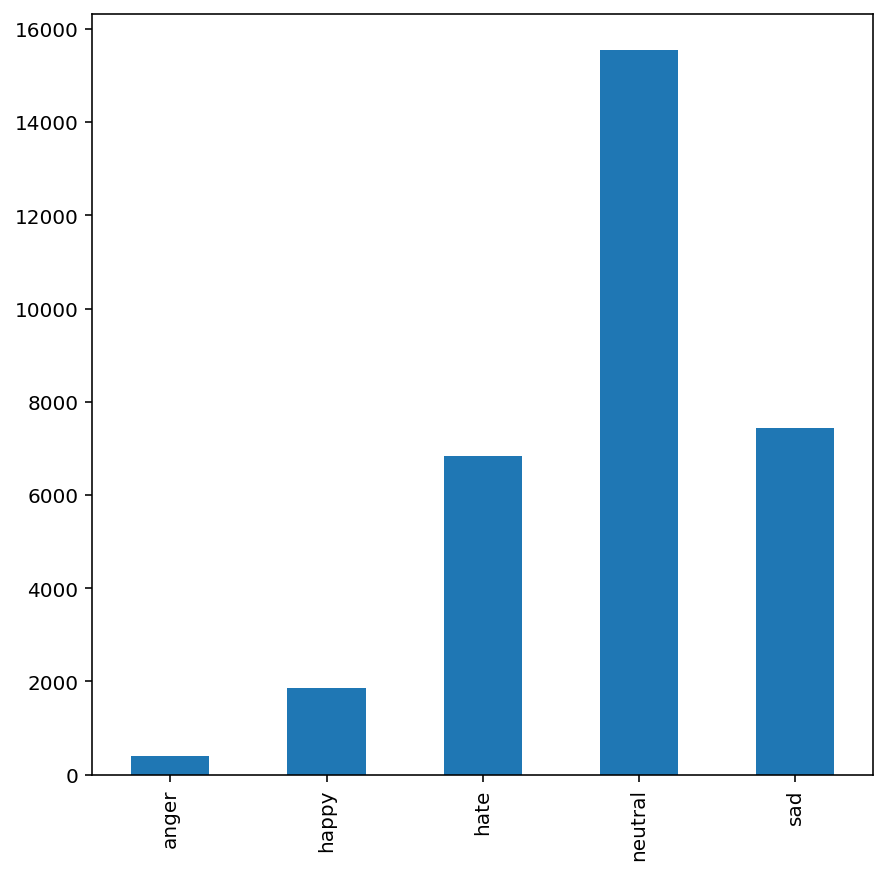

In [81]:
df_barplot1 = df_mg.sum()[['anger','happy', 'hate', 'neutral', 'sad']]
df_barplot1.plot(kind='bar', figsize=(7,7))

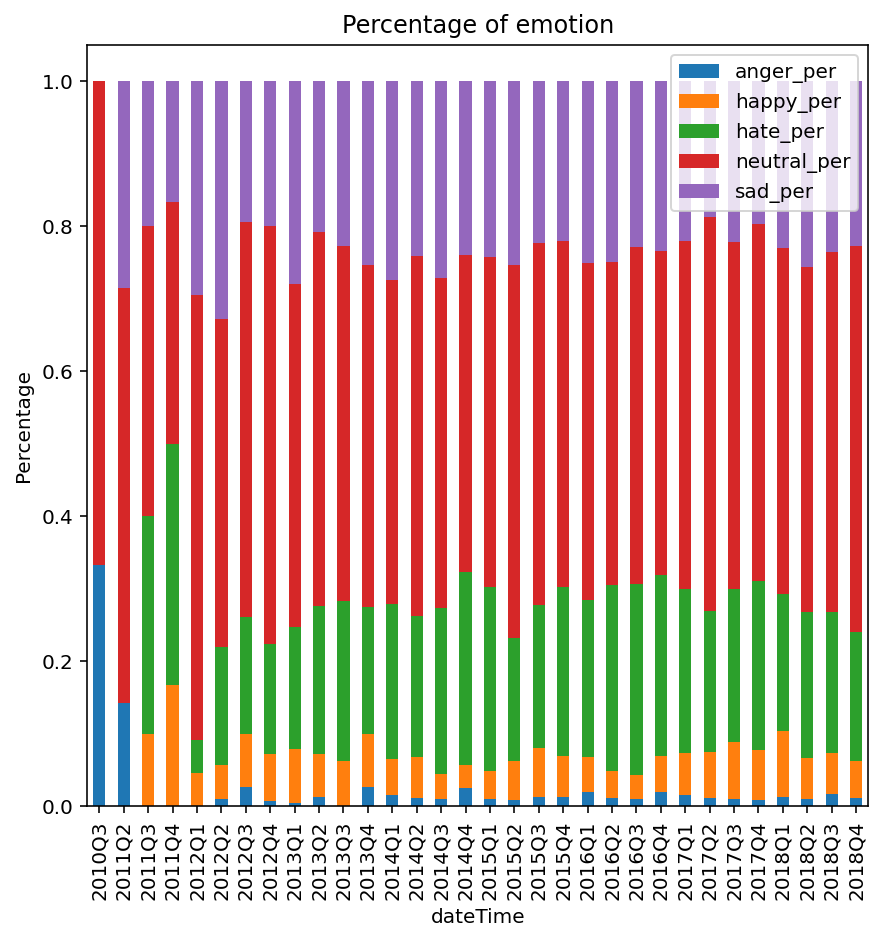

In [82]:
df_mg_plot = df_mg[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
ax = df_mg_plot.plot.bar(figsize=(7,7), stacked=True)

ax.set_ylabel('Percentage')
ax.set_title('Percentage of emotion')
ax.legend()

plt.show()

In [83]:
per = df_trump_ts.dateTime.dt.to_period("M")
g = df_trump_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']
df_mg = g.sum()
df_mg.head()
df_mg['total'] = df_mg['anger'] + df_mg['happy'] + df_mg['hate'] + df_mg['neutral']  + df_mg['sad']

df_mg['anger_per'] = df_mg['anger']/df_mg['total']
df_mg['happy_per'] = df_mg['happy']/df_mg['total']
df_mg['hate_per'] = df_mg['hate']/df_mg['total']
df_mg['neutral_per'] = df_mg['neutral']/df_mg['total']
df_mg['sad_per'] = df_mg['sad']/df_mg['total']
df_mg.head()

<ipython-input-83-9d5504846dfa>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g = df_trump_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']


,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per
dateTime,,,,,,,,,,,
2010-09,1,0,0,2,0,3,0.333333,0.000000,0.000000,0.666667,0.000000
2011-04,1,0,0,2,0,3,0.333333,0.000000,0.000000,0.666667,0.000000
2011-05,0,0,0,2,2,4,0.000000,0.000000,0.000000,0.500000,0.500000
2011-08,0,1,2,4,2,9,0.000000,0.111111,0.222222,0.444444,0.222222
2011-09,0,0,1,0,0,1,0.000000,0.000000,1.000000,0.000000,0.000000


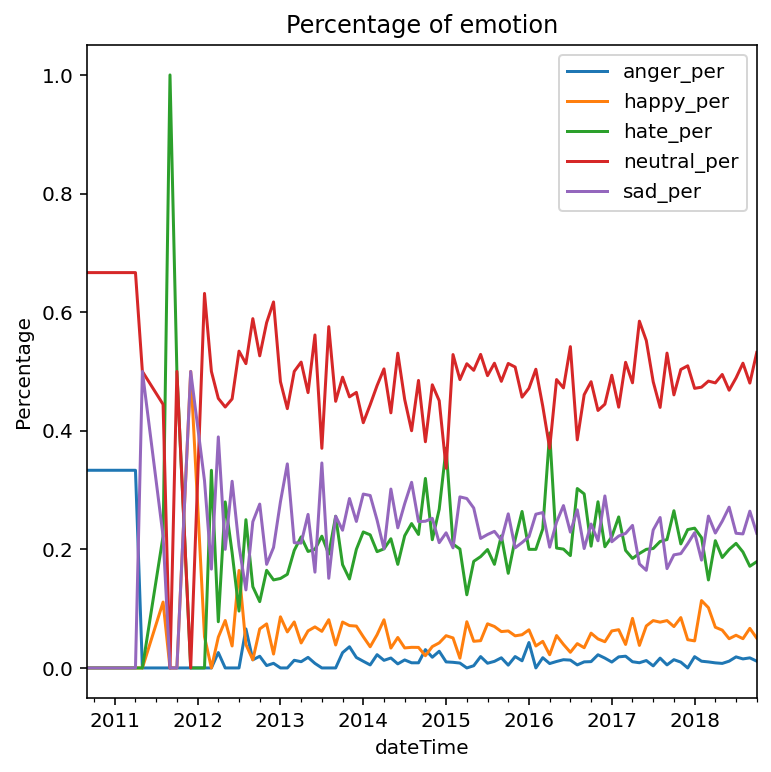

In [84]:
df_mg_plot = df_mg[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
ax = df_mg_plot.plot.line(figsize=(6,6))

ax.set_ylabel('Percentage')
ax.set_title('Percentage of emotion')
ax.legend()

plt.show()

In [85]:
from collections import Counter
teext12 = [len(x.split())>100 for x in df_trump['text']]
dict(Counter(teext12))

{False: 38008, True: 16007}

### Cosine distance

In [86]:
from scipy.spatial import distance
import dateutil.parser
from scipy.stats import ttest_ind

In [87]:
df_cosine = df_mg[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
array_d = df_cosine.values
c_distance = [0]
p_value = [0]

for x in range(len(array_d)):
    if x == 0:
        pass
    else:
        c_distance.append(distance.cosine(array_d[x], array_d[x-1]))
        p_value.append(ttest_ind(array_d[x], array_d[x-1])[1])
df_mg['c_distance'] = c_distance
# this p value isn't very representitive
df_mg['p_value'] = p_value
df_mg.head()

,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per,c_distance,p_value
dateTime,,,,,,,,,,,,,
2010-09,1,0,0,2,0,3,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,0.0
2011-04,1,0,0,2,0,3,0.333333,0.000000,0.000000,0.666667,0.000000,0.000000,1.0
2011-05,0,0,0,2,2,4,0.000000,0.000000,0.000000,0.500000,0.500000,0.367544,1.0
2011-08,0,1,2,4,2,9,0.000000,0.111111,0.222222,0.444444,0.222222,0.151472,1.0
2011-09,0,0,1,0,0,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.600000,1.0


In [88]:
df_mg_filtered = df_mg.loc['2014':]
df_mg_filtered[df_mg_filtered['c_distance'] == df_mg_filtered['c_distance'].max()]

,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per,c_distance,p_value
dateTime,,,,,,,,,,,,,
2015-02,3,16,66,167,64,316,0.009494,0.050633,0.208861,0.528481,0.202532,0.090913,1.0


In [89]:
print('2016-07 prediction: ')
print(df_mg_filtered.loc['2016-07'])
print('2016-08 prediction: ')
print(df_mg_filtered.loc['2016-08'])

2016-07 prediction: 
anger            3.000000
happy            6.000000
hate            43.000000
neutral        123.000000
sad             52.000000
total          227.000000
anger_per        0.013216
happy_per        0.026432
hate_per         0.189427
neutral_per      0.541850
sad_per          0.229075
c_distance       0.008135
p_value          1.000000
Name: 2016-07, dtype: float64
2016-08 prediction: 
anger            1.000000
happy            8.000000
hate            59.000000
neutral         75.000000
sad             52.000000
total          195.000000
anger_per        0.005128
happy_per        0.041026
hate_per         0.302564
neutral_per      0.384615
sad_per          0.266667
c_distance       0.051517
p_value          1.000000
Name: 2016-08, dtype: float64


In [91]:
df_print = df_trump_ts[(df_trump_ts['dateTime'] > '2016-07') & (df_trump_ts['dateTime'] < '2016-08')][['dateTime','text','emotion']]
for index, row in df_print.iterrows():
    print('Date: ')
    print(row.dateTime)
    print('text: ')
    print(row.text)
    print('emotion: ')
    print(row.emotion)

Date: 
2016-07-28 22:24:43
text: 
That's a much better way of measuring which I think actually bolsters my point. If these forums represented voters accurately Trump would be somewhere above 80%.

It will be interesting to watch if Hillary gets a comparable convention bump.

 I think it's fair to say the Dems have had an objectively better convention based on content and viewership, but it all means diddly squat if it doesn't convert into support.
emotion: 
['neutral', 'neutral', 'neutral', 'neutral']
Date: 
2016-07-26 18:41:43
text: 
So, let me see what you're driving at here - you are saying they aren't Sanders voters or they aren't going to vote for Trump??
emotion: 
['neutral']
Date: 
2016-07-21 19:43:52
text: 
Vote 3rd party, a vote for the establishment candidate is truly a wasted vote.

Besides emboldening the xenophobes, could trump really be worse than Hillary, I don't think he would be able to get a single bill passed.

I think having a true 3rd party hit that 15% popular vot

## Brexit

In [44]:
df_brexit = pd.read_csv('./dataset/brexit.csv')
df_brexit['Text_After_Clean'] = df_brexit['Text_After_Clean'].apply(lambda x: eval(x))
df_brexit['Text_After_Clean'] 

0       [surprise anti trump article breitbart maybe t...
1       [nah safety xenophobic blue collar uneducated,...
2                          [trump supporter brexit go, 😭]
3       [article story huffpost cambridge analytica se...
4       [available itunes blurb gang ditch regularly s...
                              ...                        
1450    [idea, shit motivation simply presume status q...
1451    [man clearly strike nerve call non american di...
1452    [sure bighouse rest convict jihadists, arrest ...
1453    [alien concept alien shove, racist gain alien ...
1454    [actually confirm correct, ty, guy get bust li...
Name: Text_After_Clean, Length: 1455, dtype: object

In [45]:
df_brexit['emotion'] = df_brexit['Text_After_Clean'].apply(lambda x: predictDf(x))

In [46]:
#df_brexit.to_csv('./dataset/brexit.csv', index=False)

In [47]:
df_brexit['emotion']

0       [hate, hate, hate, sad, neutral, hate, hate, h...
1                                             [sad, hate]
2                                      [neutral, neutral]
3       [neutral, hate, hate, neutral, neutral, neutra...
4       [sad, anger, sad, neutral, neutral, sad, neutr...
                              ...                        
1450    [neutral, neutral, neutral, sad, neutral, neut...
1451                   [hate, neutral, sad, sad, neutral]
1452    [neutral, neutral, neutral, neutral, neutral, ...
1453    [neutral, hate, hate, sad, neutral, happy, hap...
1454    [neutral, neutral, neutral, neutral, sad, neut...
Name: emotion, Length: 1455, dtype: object

In [48]:
df_brexit_ts = df_brexit[['text', 'timestamp', 'dateTime', 'emotion']]

df_brexit_ts['anger'] = ''
df_brexit_ts['happy'] = ''
df_brexit_ts['hate'] = ''
df_brexit_ts['neutral'] = ''
df_brexit_ts['sad'] = ''

for index, row in df_brexit_ts.iterrows():
    temprow = one_hot_modify(row)
    df_brexit_ts.loc[index] = temprow
df_brexit_ts

<ipython-input-48-da4d92c9e056>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brexit_ts['anger'] = ''
<ipython-input-48-da4d92c9e056>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brexit_ts['happy'] = ''
<ipython-input-48-da4d92c9e056>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,text,timestamp,dateTime,emotion,anger,happy,hate,neutral,sad
0,I'm surprised to see an anti-Trump article in ...,1469810003,2016-07-29 16:33:23,"[hate, hate, hate, sad, neutral, hate, hate, h...",0,1,10,5,1
1,"Nah, safety is not being xenophobic and blue c...",1469840250,2016-07-30 00:57:30,"[sad, hate]",0,0,1,0,1
2,Except Trump has about as many supporters as t...,1472052288,2016-08-24 15:24:48,"[neutral, neutral]",0,0,0,2,0
3,Here are some other articles about this story:...,1522154108,2018-03-27 12:35:08,"[neutral, hate, hate, neutral, neutral, neutra...",0,0,2,6,0
4,Also available on iTunes: [\n\n\_\_\_\n\nBLURB...,1524580905,2018-04-24 14:41:45,"[sad, anger, sad, neutral, neutral, sad, neutr...",1,0,2,6,3
...,...,...,...,...,...,...,...,...,...
1450,"You have no idea. Its shit, motivations, and s...",1540152461,2018-10-21 20:07:41,"[neutral, neutral, neutral, sad, neutral, neut...",0,2,1,14,4
1451,"Man, I clearly struck a nerve when I called yo...",1540399229,2018-10-24 16:40:29,"[hate, neutral, sad, sad, neutral]",0,0,1,2,2
1452,I am sure the bighouse with the rest of the co...,1540593969,2018-10-26 22:46:09,"[neutral, neutral, neutral, neutral, neutral, ...",0,0,11,35,2
1453,It's an alien concept to aliens because we sho...,1540714729,2018-10-28 08:18:49,"[neutral, hate, hate, sad, neutral, happy, hap...",0,6,9,26,6


In [49]:
df_brexit_ts['dateTime'] = pd.to_datetime(df_brexit_ts['timestamp'], unit='s')

perb = df_brexit_ts.dateTime.dt.to_period("Q")
gb = df_brexit_ts.groupby(perb)['anger','happy', 'hate', 'neutral', 'sad']
df_mgb = gb.sum()
df_mgb.head()

<ipython-input-49-fcd0c79b82c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brexit_ts['dateTime'] = pd.to_datetime(df_brexit_ts['timestamp'], unit='s')
<ipython-input-49-fcd0c79b82c0>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gb = df_brexit_ts.groupby(perb)['anger','happy', 'hate', 'neutral', 'sad']


,anger,happy,hate,neutral,sad
dateTime,,,,,
2014Q1,0,0,1,0,0
2014Q3,0,0,0,1,0
2014Q4,0,0,2,0,1
2015Q1,0,0,2,2,2
2015Q2,0,0,0,0,1


In [50]:
df_mgb['total'] = df_mgb['anger'] + df_mgb['happy'] + df_mgb['hate'] + df_mgb['neutral']  + df_mgb['sad']

df_mgb['anger_per'] = df_mgb['anger']/df_mgb['total']
df_mgb['happy_per'] = df_mgb['happy']/df_mgb['total']
df_mgb['hate_per'] = df_mgb['hate']/df_mgb['total']
df_mgb['neutral_per'] = df_mgb['neutral']/df_mgb['total']
df_mgb['sad_per'] = df_mgb['sad']/df_mgb['total']
print(df_mgb.head())

print('angle ' + str(df_mgb['anger'].sum()))
print('happy ' + str(df_mgb['happy'].sum()))
print('hate ' + str(df_mgb['hate'].sum()))
print('neutral ' + str(df_mgb['neutral'].sum()))
print('sad ' + str(df_mgb['sad'].sum()))

          anger  happy  hate  neutral  sad  total  anger_per  happy_per  \
dateTime                                                                  
2014Q1        0      0     1        0    0      1        0.0        0.0   
2014Q3        0      0     0        1    0      1        0.0        0.0   
2014Q4        0      0     2        0    1      3        0.0        0.0   
2015Q1        0      0     2        2    2      6        0.0        0.0   
2015Q2        0      0     0        0    1      1        0.0        0.0   

          hate_per  neutral_per   sad_per  
dateTime                                   
2014Q1    1.000000     0.000000  0.000000  
2014Q3    0.000000     1.000000  0.000000  
2014Q4    0.666667     0.000000  0.333333  
2015Q1    0.333333     0.333333  0.333333  
2015Q2    0.000000     0.000000  1.000000  
angle 116
happy 699
hate 1828
neutral 5937
sad 2927


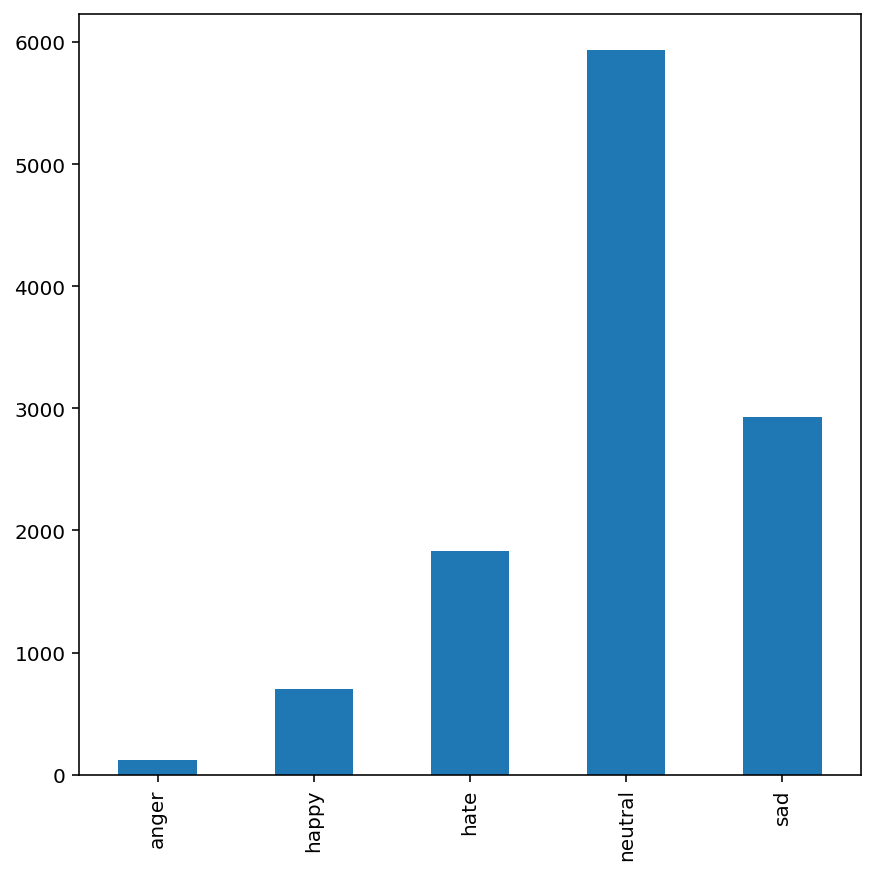

In [51]:
df_barplot2 = df_mgb.sum()[['anger','happy', 'hate', 'neutral', 'sad']]
df_barplot2.plot(kind='bar', figsize=(7,7))

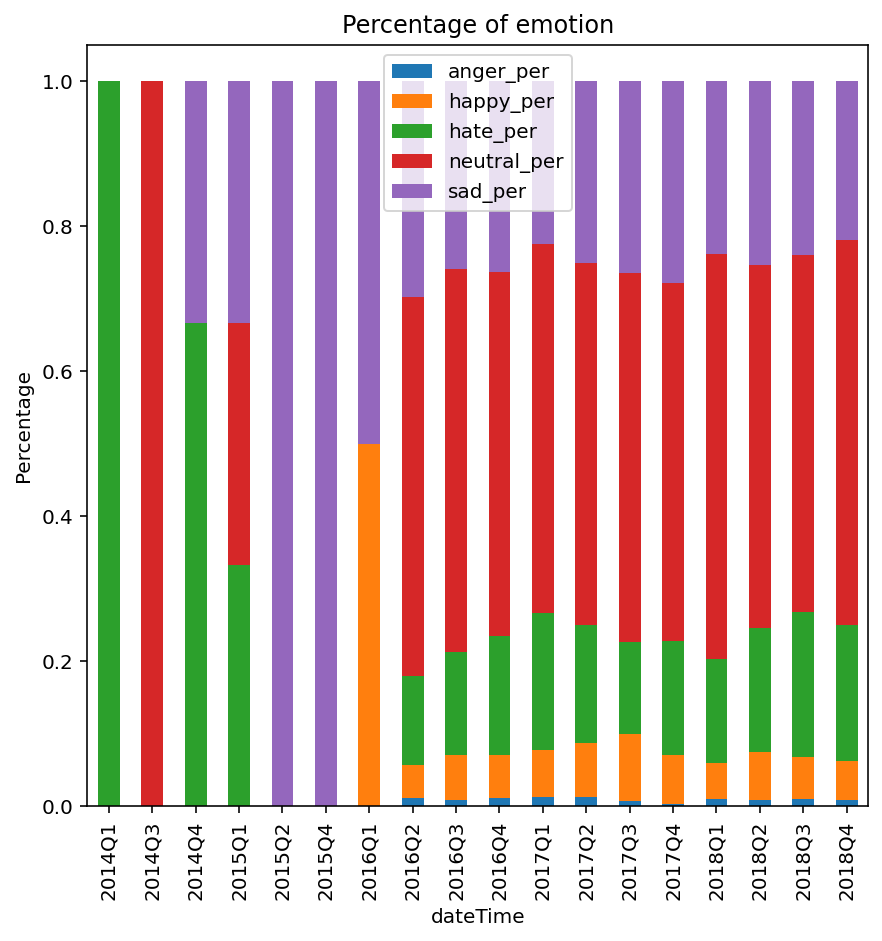

In [52]:
df_mgb_plot = df_mgb[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
ax = df_mgb_plot.plot.bar(figsize=(7,7), stacked=True)

ax.set_ylabel('Percentage')
ax.set_title('Percentage of emotion')
ax.legend()

plt.show()

In [53]:
per = df_brexit_ts.dateTime.dt.to_period("M")
g = df_brexit_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']
df_mg = g.sum()
df_mg.head()
df_mg['total'] = df_mg['anger'] + df_mg['happy'] + df_mg['hate'] + df_mg['neutral']  + df_mg['sad']

df_mg['anger_per'] = df_mg['anger']/df_mg['total']
df_mg['happy_per'] = df_mg['happy']/df_mg['total']
df_mg['hate_per'] = df_mg['hate']/df_mg['total']
df_mg['neutral_per'] = df_mg['neutral']/df_mg['total']
df_mg['sad_per'] = df_mg['sad']/df_mg['total']
df_mg.head()

<ipython-input-53-386741e6fc5f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g = df_brexit_ts.groupby(per)['anger','happy', 'hate', 'neutral', 'sad']


,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per
dateTime,,,,,,,,,,,
2014-01,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0
2014-09,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0
2014-10,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0
2014-11,0,0,1,0,1,2,0.0,0.0,0.5,0.0,0.5
2015-01,0,0,2,0,2,4,0.0,0.0,0.5,0.0,0.5


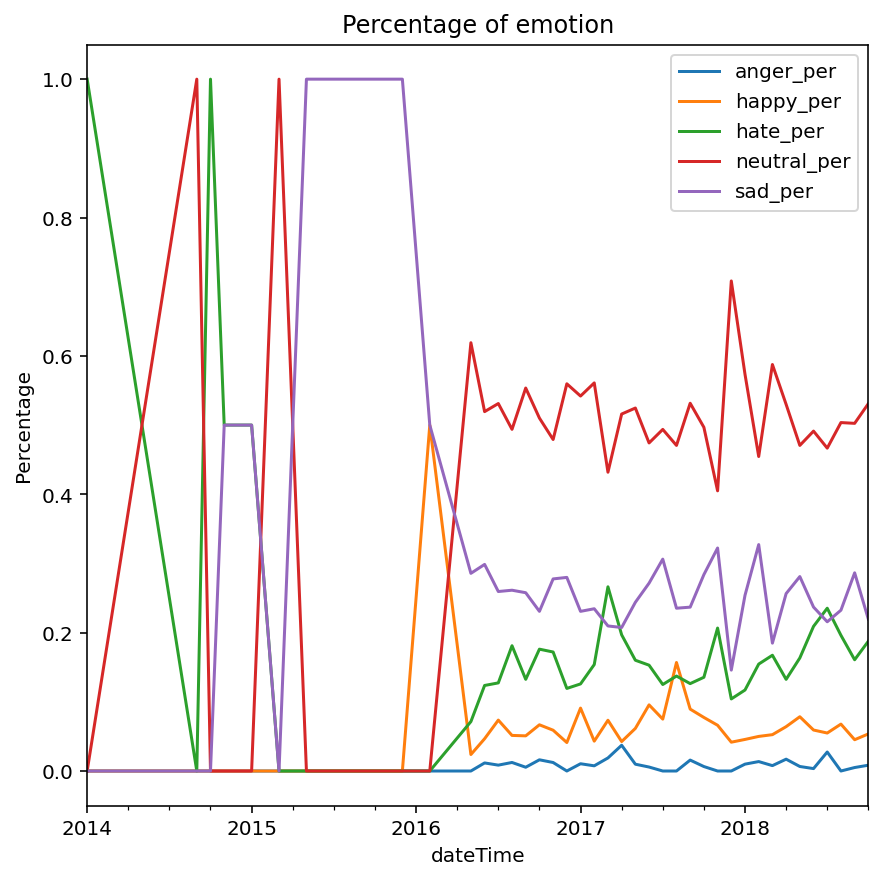

In [54]:
df_mg_plot = df_mg[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
ax = df_mg_plot.plot.line(figsize=(7,7))

ax.set_ylabel('Percentage')
ax.set_title('Percentage of emotion')
ax.legend()

plt.show()

In [58]:
from collections import Counter
teext12 = [len(x.split())>100 for x in df_brexit['text']]
dict(Counter(teext12))

{True: 644, False: 811}

In [59]:
df_cosine = df_mg[['anger_per','happy_per', 'hate_per', 'neutral_per', 'sad_per']]
array_d = df_cosine.values
c_distance = [0]
p_value = [0]

for x in range(len(array_d)):
    if x == 0:
        pass
    else:
        c_distance.append(distance.cosine(array_d[x], array_d[x-1]))
        p_value.append(ttest_ind(array_d[x], array_d[x-1])[1])
df_mg['c_distance'] = c_distance
# this p value isn't very representitive
df_mg['p_value'] = p_value
df_mg.head()

,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per,c_distance,p_value
dateTime,,,,,,,,,,,,,
2014-01,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0,0.000000,0.0
2014-09,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,1.000000,1.0
2014-10,0,0,1,0,0,1,0.0,0.0,1.0,0.0,0.0,1.000000,1.0
2014-11,0,0,1,0,1,2,0.0,0.0,0.5,0.0,0.5,0.292893,1.0
2015-01,0,0,2,0,2,4,0.0,0.0,0.5,0.0,0.5,0.000000,1.0


In [60]:
df_mg_filtered = df_mg.loc['2016-06':]
df_mg_filtered[df_mg_filtered['c_distance'] == df_mg_filtered['c_distance'].max()]

,anger,happy,hate,neutral,sad,total,anger_per,happy_per,hate_per,neutral_per,sad_per,c_distance,p_value
dateTime,,,,,,,,,,,,,
2017-12,0,2,5,34,7,48,0.0,0.041667,0.104167,0.708333,0.145833,0.128017,1.0


In [61]:
print('2018-02 prediction: ')
print(df_mg_filtered.loc['2018-02'])
print('2018-03 prediction: ')
print(df_mg_filtered.loc['2018-03'])

2018-02 prediction: 
anger            3.000000
happy           11.000000
hate            34.000000
neutral        100.000000
sad             72.000000
total          220.000000
anger_per        0.013636
happy_per        0.050000
hate_per         0.154545
neutral_per      0.454545
sad_per          0.327273
c_distance       0.023807
p_value          1.000000
Name: 2018-02, dtype: float64
2018-03 prediction: 
anger            4.000000
happy           27.000000
hate            86.000000
neutral        302.000000
sad             95.000000
total          514.000000
anger_per        0.007782
happy_per        0.052529
hate_per         0.167315
neutral_per      0.587549
sad_per          0.184825
c_distance       0.046737
p_value          1.000000
Name: 2018-03, dtype: float64


In [65]:
df_print = df_brexit_ts[(df_brexit_ts['dateTime'] > '2018-02') & (df_brexit_ts['dateTime'] < '2018-03')][['dateTime','text','emotion']]
for index, row in df_print.iterrows():
    print('Date: ')
    print(row.dateTime)
    print('text: ')
    print(row.text)
    print('emotion: ')
    print(row.emotion)

Date: 
2018-02-01 21:48:57
text: 
Maybe voters view it as stability?  But it has it's limits, as we've seen from the Obama and Trump victories, and Brexit.  Out with the old oligarchs, in with the new?
emotion: 
['neutral', 'neutral', 'neutral']
Date: 
2018-02-01 22:21:41
text: 
I wrote a long comment elaborating on why I think so many young people are losing faith in democracy, but my computer crashed so here's the cliff notes version:

* Political Gridlock in the U.S. due to sharp partisans divides, inaction on important issues like Climate Change among young people compared to the frequent News that China has invested more into solar, Add in a generational divide ("damn baby boomers are holding us back") that makes people feel like they are being held hostage and have no actual voice

* Lack of apparent power of voting. From pointless voting in safe seats ("This is a conservative safe seat, if I vote Liberal there's no point. and "This is a Liberal safe seat, even if I vote Liberal 

In [64]:
df_brexit_ts

,text,timestamp,dateTime,emotion,anger,happy,hate,neutral,sad
0,I'm surprised to see an anti-Trump article in ...,1469810003,2016-07-29 16:33:23,"[hate, hate, hate, sad, neutral, hate, hate, h...",0,1,10,5,1
1,"Nah, safety is not being xenophobic and blue c...",1469840250,2016-07-30 00:57:30,"[sad, hate]",0,0,1,0,1
2,Except Trump has about as many supporters as t...,1472052288,2016-08-24 15:24:48,"[neutral, neutral]",0,0,0,2,0
3,Here are some other articles about this story:...,1522154108,2018-03-27 12:35:08,"[neutral, hate, hate, neutral, neutral, neutra...",0,0,2,6,0
4,Also available on iTunes: [\n\n\_\_\_\n\nBLURB...,1524580905,2018-04-24 14:41:45,"[sad, anger, sad, neutral, neutral, sad, neutr...",1,0,2,6,3
...,...,...,...,...,...,...,...,...,...
1450,"You have no idea. Its shit, motivations, and s...",1540152461,2018-10-21 20:07:41,"[neutral, neutral, neutral, sad, neutral, neut...",0,2,1,14,4
1451,"Man, I clearly struck a nerve when I called yo...",1540399229,2018-10-24 16:40:29,"[hate, neutral, sad, sad, neutral]",0,0,1,2,2
1452,I am sure the bighouse with the rest of the co...,1540593969,2018-10-26 22:46:09,"[neutral, neutral, neutral, neutral, neutral, ...",0,0,11,35,2
1453,It's an alien concept to aliens because we sho...,1540714729,2018-10-28 08:18:49,"[neutral, hate, hate, sad, neutral, happy, hap...",0,6,9,26,6
